# Airfoil Noise Benchmark

This notebook benchmarks **Full Info vs Partial vs GGH Soft Refinement** on the Airfoil Self-Noise dataset.

**Dataset**: NASA Airfoil Self-Noise (1503 samples, 6 hypothesis values for chord-length)

**Methods Compared**:
1. **Full Info** (Oracle): Uses all data with correct hypothesis values
2. **Partial**: Uses only 4% of samples with known correct hypotheses  
3. **GGH Soft Refinement**: Uses gradient-guided hypothesis selection with soft weighting

**Expected Results** (4% partial):
- Full Info R2: ~0.83 (upper bound)
- Partial Info R2: ~0.40 (baseline)
- GGH R2: Between Partial and Full Info

**Key Adaptations for 6 Hypotheses**:
- Baseline random precision: 16.7% (1/6)
- Soft weighting (min_weight=0.1) instead of hard percentile cutoffs

In [1]:
# CUDA determinism fix (must be before torch import)
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators
from GGH.models import initialize_model
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector
from scipy import stats
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def set_to_deterministic(rand_state):
    import random
    random.seed(rand_state)
    np.random.seed(rand_state)
    torch.manual_seed(rand_state)
    torch.set_num_threads(1)
    torch.use_deterministic_algorithms(True)

print("Imports successful!")

# GPU Detection
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Imports successful!


In [2]:
# =============================================================================
# DATA CONFIGURATION - Airfoil Self-Noise Dataset
# =============================================================================
data_path = '../data/airfoil_self_noise/data.csv'
results_path = "../saved_results/Airfoil Benchmark"

# Variables
inpt_vars = ['frequency', 'attack-angle', 'free-stream-velocity', 'suction-side-displacement-thickness']
target_vars = ['scaled-sound-pressure']
miss_vars = ['chord-length']

# Hypothesis values (6 chord-length values in meters)
hypothesis = [[0.0254, 0.0508, 0.1016, 0.1524, 0.2286, 0.3048]]

# Model parameters
hidden_size = 32
output_size = len(target_vars)
hyp_per_sample = len(hypothesis[0])  # 6 hypotheses
batch_size = 100 * hyp_per_sample

# Training parameters (from original notebook)
partial_perc = 0.03  # 4% complete data (NOT 8%)
dropout = 0.05
lr = 0.004
nu = 0.1

# Benchmark parameters (matching original multi_experiments)
BENCHMARK_N_RUNS = 15
BENCHMARK_EPOCHS = 500  # int(200*2.5) - same for both full and partial

# Create directories
import os
os.makedirs(results_path, exist_ok=True)

print(f"Dataset: Airfoil Self-Noise")
print(f"Input variables: {inpt_vars}")
print(f"Target: {target_vars}")
print(f"Missing variable: {miss_vars}")
print(f"Hypothesis values: {hypothesis[0]}")
print(f"Number of hypotheses: {hyp_per_sample}")
print(f"Partial percentage: {partial_perc*100}%")
print(f"Epochs: {BENCHMARK_EPOCHS}")
print(f"Results will be saved to: {results_path}")


def full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, results_path, 
                    dropout=0.05, lr=0.004, nu=0.1, final_analysis=False):
    """Exact copy of full_experiment from original notebook."""
    AM = AlgoModulators(DO, lr=lr, nu=nu)
    dataloader = DO.prep_dataloader(use_info, batch_size)
    
    model = initialize_model(DO, dataloader, hidden_size, rand_state, dropout=dropout)
    
    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, rand_state, 
                                 results_path, final_analysis=final_analysis)
    TVM.train_model(DO, AM, model, final_analysis=final_analysis)
    
    INSPECT.save_train_val_logs(DO, AM, TVM, model, final_analysis=final_analysis)
    
    return DO, TVM, model

Dataset: Airfoil Self-Noise
Input variables: ['frequency', 'attack-angle', 'free-stream-velocity', 'suction-side-displacement-thickness']
Target: ['scaled-sound-pressure']
Missing variable: ['chord-length']
Hypothesis values: [0.0254, 0.0508, 0.1016, 0.1524, 0.2286, 0.3048]
Number of hypotheses: 6
Partial percentage: 3.0%
Epochs: 500
Results will be saved to: ../saved_results/Airfoil Benchmark


## Benchmark: Partial vs Full Info

In [ ]:
# =============================================================================
# BENCHMARK: Full Info vs Partial Info
# =============================================================================
# Using the EXACT same flow as the original notebook's multi_experiments
# =============================================================================

print("=" * 80)
print("BENCHMARK: Full Info vs Partial Info on Airfoil Self-Noise")
print("=" * 80)
print(f"Full Info: {BENCHMARK_EPOCHS} epochs, all data with correct hypothesis")
print(f"Partial Info: {BENCHMARK_EPOCHS} epochs, only {partial_perc*100}% partial data")
print(f"Number of runs: {BENCHMARK_N_RUNS}")
print(f"Hyperparameters: lr={lr}, dropout={dropout}, nu={nu}")
print("=" * 80)

results = []
valid_runs = 0

# Iterate through r_states starting from 0, same as original multi_experiments
for r_state in range(2000):
    if valid_runs >= BENCHMARK_N_RUNS:
        break
    
    # Set deterministic (same as multi_experiments)
    set_to_deterministic(r_state)
    
    # Create DataOperator
    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                      partial_perc, r_state, device=DEVICE)
    
    # Skip if lack of partial coverage (same as original)
    if DO.lack_partial_coverage:
        continue
    
    print(f"\n{'='*60}")
    print(f"RUN {valid_runs + 1}/{BENCHMARK_N_RUNS} (rand_state={r_state})")
    print(f"{'='*60}")
    
    # Create Inspector (same as original)
    INSPECT = Inspector(results_path, hidden_size)
    
    # === Run Full Info (same r_state as original) ===
    print(f"Training Full Info model ({BENCHMARK_EPOCHS} epochs)...")
    set_to_deterministic(r_state)
    DO_full = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                           partial_perc, r_state, device=DEVICE)
    DO_full, TVM_full, model_full = full_experiment(
        "full info", DO_full, INSPECT, batch_size, hidden_size, output_size, 
        BENCHMARK_EPOCHS, r_state, results_path, dropout, lr, nu, final_analysis=False
    )
    r2_full = INSPECT.calculate_val_r2score(DO_full, TVM_full, model_full, data="test")
    print(f"Full Info R2: {r2_full:.4f}")
    
    # === Run Partial Info (same r_state as original) ===
    print(f"Training Partial Info model ({BENCHMARK_EPOCHS} epochs)...")
    set_to_deterministic(r_state)
    DO_partial = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                              partial_perc, r_state, device=DEVICE)
    DO_partial, TVM_partial, model_partial = full_experiment(
        "partial info", DO_partial, INSPECT, batch_size, hidden_size, output_size,
        BENCHMARK_EPOCHS, r_state, results_path, dropout, lr, nu, final_analysis=False
    )
    r2_partial = INSPECT.calculate_val_r2score(DO_partial, TVM_partial, model_partial, data="test")
    print(f"Partial Info R2: {r2_partial:.4f}")
    
    # Store results
    results.append({
        'rand_state': r_state,
        'r2_full': r2_full,
        'r2_partial': r2_partial,
        'improvement': r2_full - r2_partial,
    })
    
    print(f">>> Full Info improvement over Partial: {results[-1]['improvement']:+.4f}")
    
    valid_runs += 1


# =============================================================================
# SUMMARY
# =============================================================================
print(f"\n{'='*80}")
print("BENCHMARK RESULTS: Full Info vs Partial Info")
print(f"{'='*80}")

# Print detailed table
print("\nDetailed Results:")
print(f"{'Run':<5} {'r_state':<10} {'R2 Full':<12} {'R2 Partial':<12} {'Δ R2':<10}")
print("-" * 55)
for i, r in enumerate(results):
    print(f"{i+1:<5} {r['rand_state']:<10} {r['r2_full']:<12.4f} {r['r2_partial']:<12.4f} {r['improvement']:+10.4f}")

# Summary statistics
r2_fulls = [r['r2_full'] for r in results]
r2_partials = [r['r2_partial'] for r in results]

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"\nTest R2 Score:")
print(f"  Full Info:    {np.mean(r2_fulls):.4f} ± {np.std(r2_fulls):.4f}")
print(f"  Partial Info: {np.mean(r2_partials):.4f} ± {np.std(r2_partials):.4f}")

# Statistical test
t_stat, p_value = stats.ttest_rel(r2_fulls, r2_partials)
print(f"\nStatistical Test (paired t-test):")
print(f"  t={t_stat:.3f}, p={p_value:.6f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''}")

# Win count
n_full_wins = sum(1 for r in results if r['r2_full'] > r['r2_partial'])
print(f"\nWin Rate:")
print(f"  Full Info wins: {n_full_wins}/{BENCHMARK_N_RUNS} ({n_full_wins/BENCHMARK_N_RUNS*100:.1f}%)")

# Expected results at 4% partial
print(f"\n{'='*80}")
print("EXPECTED RESULTS (from original notebook at 4% partial):")
print("  Full Info:    ~0.83")
print("  Partial Info: ~0.40")
print(f"{'='*80}")

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

x = np.arange(BENCHMARK_N_RUNS)
width = 0.35

ax.bar(x - width/2, r2_fulls, width, label='Full Info', color='green', alpha=0.7)
ax.bar(x + width/2, r2_partials, width, label='Partial Info', color='orange', alpha=0.7)
ax.set_xlabel('Run')
ax.set_ylabel('Test R2')
ax.set_title(f'Airfoil Self-Noise: Full Info vs Partial Info ({partial_perc*100}% partial)')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels([str(i+1) for i in range(BENCHMARK_N_RUNS)])
ax.axhline(y=np.mean(r2_fulls), color='green', linestyle='--', alpha=0.5)
ax.axhline(y=np.mean(r2_partials), color='orange', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(f'{results_path}/full_vs_partial_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

# Final verdict
print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
avg_improvement = np.mean([r['improvement'] for r in results])
print(f"Full Info significantly outperforms Partial Info (p={p_value:.6f})")
print(f"Average R2 improvement: {avg_improvement:.4f}")
print(f"\nThis gap ({avg_improvement:.4f}) represents the potential for GGH to improve upon Partial.")

## GGH Soft Weight Iterative Refinement

The GGH method uses soft weights instead of hard selection:
1. **Iter1**: Unbiased training → enriched scores → initial soft weights
2. **Iter2**: Weighted training on ALL samples (different weights) + partial
3. **Iter3**: Biased rescoring → multiply weights (iterative refinement)
4. **Iter4**: Loss-based adjustment → final weights
5. **Final**: Train with refined weights + dynamic partial

**Key Parameters (adapted for 6 hypotheses)**:
- Baseline random: 16.7% (1/6)
- Top percentile concept replaced by soft weighting (min_weight=0.1)
- Temperature parameters control weight distribution sharpness

In [4]:
# =============================================================================
# GGH SOFT WEIGHT ITERATIVE REFINEMENT - Adapted for 6 Hypothesis Classes
# =============================================================================
from torch.autograd import grad

# === GGH CONFIGURATION (adapted for 6 hypotheses) ===
GGH_ITER1_EPOCHS = 60              # 60 epochs unbiased
GGH_ITER1_ANALYSIS_EPOCHS = 5      # Last 5 tracked
GGH_ITER1_LR = 0.01
GGH_ITER2_EPOCHS = 30              # 30 epochs weighted training
GGH_ITER2_LR = 0.01
GGH_SCORING_PASSES = 5             # 5 passes for scoring
GGH_FINAL_EPOCHS = 200             # Final training epochs

# Soft Weighting Parameters
GGH_MIN_WEIGHT = 0.1               # No sample below this weight
GGH_TEMPERATURE_ITER1 = 1.0        # Sharpness of Iter1 weight distribution
GGH_TEMPERATURE_ITER3 = 0.8        # Sharpness of Iter3 weight distribution
GGH_LOSS_INFLUENCE = 0.25          # How much loss affects final weights
GGH_PARTIAL_BASE_WEIGHT = 2.0      # Base partial weight
GGH_BENCHMARK_LR = 0.01            # LR for final training

# Model architecture
MODEL_SHARED_HIDDEN = 16
MODEL_HYPOTHESIS_HIDDEN = 32
MODEL_FINAL_HIDDEN = 32


# === MODEL DEFINITIONS ===
class HypothesisAmplifyingModel(nn.Module):
    """
    Neural network that amplifies the impact of hypothesis feature on gradients.
    Shared features path (smaller) + Hypothesis feature path (larger).
    """
    def __init__(self, n_shared_features, n_hypothesis_features=1, 
                 shared_hidden=16, hypothesis_hidden=32, final_hidden=32, output_size=1):
        super().__init__()
        
        self.shared_path = nn.Sequential(
            nn.Linear(n_shared_features, shared_hidden),
            nn.ReLU(),
        )
        
        self.hypothesis_path = nn.Sequential(
            nn.Linear(n_hypothesis_features, hypothesis_hidden),
            nn.ReLU(),
            nn.Linear(hypothesis_hidden, hypothesis_hidden),
            nn.ReLU(),
        )
        
        combined_size = shared_hidden + hypothesis_hidden
        self.final_path = nn.Sequential(
            nn.Linear(combined_size, final_hidden),
            nn.ReLU(),
            nn.Linear(final_hidden, output_size)
        )
        
        self.n_shared = n_shared_features
        
    def forward(self, x):
        shared_features = x[:, :self.n_shared]
        hypothesis_feature = x[:, self.n_shared:]
        
        shared_emb = self.shared_path(shared_features)
        hypothesis_emb = self.hypothesis_path(hypothesis_feature)
        
        combined = torch.cat([shared_emb, hypothesis_emb], dim=1)
        return self.final_path(combined)


# === TRAINER CLASSES ===
class UnbiasedTrainer:
    """Train on ALL hypotheses equally. Track per-hypothesis losses and gradients."""
    def __init__(self, DO, model, lr=0.001, device=DEVICE):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        self.loss_history = {}
        self.gradient_history = {}
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        self.model.train()
        total_loss = 0
        num_batches = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            predictions = self.model(inputs)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            batch_loss = individual_losses.mean()
            
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()
            
            total_loss += batch_loss.item()
            num_batches += 1
        
        return total_loss / num_batches
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        analysis = {}
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis


class WeightedTrainer:
    """Train on ALL samples with continuous weights."""
    def __init__(self, DO, model, sample_weights, partial_gids, partial_weight, lr=0.001, device=DEVICE):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        self.sample_weights = sample_weights
        self.partial_gids = set(partial_gids)
        self.partial_weight = partial_weight
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        self.model.train()
        total_loss = 0
        total_weight = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            predictions = self.model(inputs)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            
            weights = torch.zeros(len(inputs), device=self.device)
            
            for i, gid in enumerate(global_ids):
                gid = gid.item()
                if gid in self.partial_gids:
                    weights[i] = self.partial_weight
                elif gid in self.sample_weights:
                    weights[i] = self.sample_weights[gid]
            
            if weights.sum() == 0:
                continue
            
            weighted_loss = (individual_losses * weights).sum() / weights.sum()
            
            self.optimizer.zero_grad()
            weighted_loss.backward()
            self.optimizer.step()
            
            total_loss += weighted_loss.item() * weights.sum().item()
            total_weight += weights.sum().item()
        
        return total_loss / total_weight if total_weight > 0 else 0


class RemainingDataScorer:
    """Score remaining data using biased model."""
    def __init__(self, DO, model, remaining_sample_indices, device=DEVICE):
        self.DO = DO
        self.model = model
        self.device = device
        self.hyp_per_sample = DO.num_hyp_comb
        self.remaining_sample_indices = set(remaining_sample_indices)
        
        self.loss_scores = {}
        self.gradient_history = {}
        
    def compute_scores(self, dataloader, n_passes=5):
        self.model.eval()
        
        for pass_idx in range(n_passes):
            for inputs, targets, global_ids in dataloader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                for i in range(len(inputs)):
                    gid = global_ids[i].item()
                    sample_idx = gid // self.hyp_per_sample
                    
                    if sample_idx not in self.remaining_sample_indices:
                        continue
                    
                    inp = inputs[i:i+1].clone().requires_grad_(True)
                    pred = self.model(inp)
                    loss = nn.MSELoss()(pred, targets[i:i+1])
                    
                    if gid not in self.loss_scores:
                        self.loss_scores[gid] = []
                    self.loss_scores[gid].append(loss.item())
                    
                    params = list(self.model.parameters())
                    grad_param = grad(loss, params[-2], retain_graph=False)[0]
                    grad_vec = grad_param.flatten().detach().cpu().numpy()
                    
                    if gid not in self.gradient_history:
                        self.gradient_history[gid] = []
                    self.gradient_history[gid].append(grad_vec)
    
    def get_analysis(self):
        analysis = {}
        for gid in self.loss_scores:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_scores[gid]),
                'loss_std': np.std(self.loss_scores[gid]),
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis


# === UTILITY FUNCTIONS ===
def sigmoid_stable(x):
    """Numerically stable sigmoid."""
    x = np.array(x, dtype=np.float64)
    return np.where(x >= 0,
                    1 / (1 + np.exp(-x)),
                    np.exp(x) / (1 + np.exp(x)))


def compute_soft_weights(scores, min_weight=0.1, temperature=1.0):
    """Convert scores to soft weights using sigmoid."""
    scores = np.array(scores, dtype=np.float64)
    if len(scores) == 0:
        return np.array([])
    
    mean_s = np.mean(scores)
    std_s = np.std(scores) + 1e-8
    normalized = (scores - mean_s) / std_s
    
    raw_weights = sigmoid_stable(normalized / temperature)
    weights = min_weight + (1 - min_weight) * raw_weights
    
    return weights


def create_dataloader_with_gids(DO, batch_size=32):
    """Create dataloader that includes global_ids."""
    input_cols = DO.inpt_vars + [var + '_hypothesis' for var in DO.miss_vars]
    n_samples = len(DO.df_train_hypothesis)
    global_ids = torch.arange(n_samples)
    
    dataset = TensorDataset(
        torch.tensor(DO.df_train_hypothesis[input_cols].values, dtype=torch.float32),
        torch.tensor(DO.df_train_hypothesis[DO.target_vars].values, dtype=torch.float32),
        global_ids
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


def compute_anchor_data(trainer, DO):
    """Compute gradient-only anchors AND enriched anchors for each class."""
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    input_cols = DO.inpt_vars
    
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    anchor_correct_grad = {}
    anchor_incorrect_grad = {}
    anchor_correct_enriched = {}
    anchor_incorrect_enriched = {}
    feature_norm_params = {}
    
    all_grads = [analysis[gid]['avg_gradient'] for gid in analysis 
                 if analysis[gid]['avg_gradient'] is not None]
    grad_scale = float(np.mean([np.linalg.norm(g) for g in all_grads])) if all_grads else 1.0
    
    for class_id in range(hyp_per_sample):
        class_correct_gids = [gid for gid in partial_correct_gids 
                              if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        class_incorrect_gids = [gid for gid in blacklisted_gids 
                                if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        
        correct_grads = []
        correct_features = []
        for gid in class_correct_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                correct_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                correct_features.append(feat)
        
        incorrect_grads = []
        incorrect_features = []
        for gid in class_incorrect_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                incorrect_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                incorrect_features.append(feat)
        
        if not correct_grads or not incorrect_grads:
            continue
            
        anchor_correct_grad[class_id] = np.mean(correct_grads, axis=0)
        anchor_incorrect_grad[class_id] = np.mean(incorrect_grads, axis=0)
        
        correct_grads = np.array(correct_grads, dtype=np.float64)
        incorrect_grads = np.array(incorrect_grads, dtype=np.float64)
        correct_features = np.array(correct_features, dtype=np.float64)
        incorrect_features = np.array(incorrect_features, dtype=np.float64)
        
        all_features = np.vstack([correct_features, incorrect_features])
        feat_mean = np.mean(all_features, axis=0)
        feat_std = np.std(all_features, axis=0) + 1e-8
        
        feature_norm_params[class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
        
        correct_features_norm = (correct_features - feat_mean) / feat_std * grad_scale
        incorrect_features_norm = (incorrect_features - feat_mean) / feat_std * grad_scale
        
        correct_enriched = np.hstack([correct_grads, correct_features_norm])
        incorrect_enriched = np.hstack([incorrect_grads, incorrect_features_norm])
        
        anchor_correct_enriched[class_id] = np.mean(correct_enriched, axis=0)
        anchor_incorrect_enriched[class_id] = np.mean(incorrect_enriched, axis=0)
    
    return {
        'anchor_correct_grad': anchor_correct_grad,
        'anchor_incorrect_grad': anchor_incorrect_grad,
        'anchor_correct_enriched': anchor_correct_enriched,
        'anchor_incorrect_enriched': anchor_incorrect_enriched,
        'grad_scale': grad_scale,
        'feature_norm_params': feature_norm_params,
        'partial_correct_gids': partial_correct_gids,
        'blacklisted_gids': blacklisted_gids,
        'partial_sample_indices': partial_sample_indices,
        'input_cols': input_cols
    }


def compute_enriched_score(gradient, features, class_id, anchor_data):
    """Compute enriched score (gradient + normalized features)."""
    norm_params = anchor_data.get('feature_norm_params', {}).get(class_id)
    if norm_params:
        features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
    else:
        grad_scale = anchor_data.get('grad_scale', 1.0)
        features_norm = features * grad_scale / (np.linalg.norm(features) + 1e-8)
    
    enriched = np.concatenate([gradient, features_norm])
    anchor_c = anchor_data.get('anchor_correct_enriched', {}).get(class_id)
    anchor_i = anchor_data.get('anchor_incorrect_enriched', {}).get(class_id)
    
    if anchor_c is None:
        anchor_c = anchor_data.get('anchor_correct_grad', {}).get(class_id)
        anchor_i = anchor_data.get('anchor_incorrect_grad', {}).get(class_id)
        enriched = gradient
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


def compute_enriched_score_with_loss(gradient, features, loss, class_id, anchor_data):
    """Compute enriched score with loss included."""
    norm_params = anchor_data.get('feature_norm_params', {}).get(class_id)
    loss_params = anchor_data.get('loss_norm_params', {}).get(class_id)
    grad_scale = anchor_data.get('grad_scale', 1.0)
    
    if norm_params:
        features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
    else:
        features_norm = features * grad_scale / (np.linalg.norm(features) + 1e-8)
    
    if loss_params:
        loss_norm = -((loss - loss_params['mean']) / loss_params['std']) * loss_params['scale']
    else:
        loss_norm = -loss * grad_scale
    
    enriched = np.concatenate([gradient, features_norm, [loss_norm]])
    
    anchor_c = anchor_data.get('anchor_correct_enriched', {}).get(class_id)
    anchor_i = anchor_data.get('anchor_incorrect_enriched', {}).get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


def evaluate_on_test(DO, model):
    """Evaluate model on test set."""
    model.eval()
    with torch.no_grad():
        test_inputs, test_targets = DO.get_test_tensors(use_info="full info")
        test_preds = model(test_inputs)
        test_loss = torch.nn.functional.mse_loss(test_preds, test_targets).item()
        test_mae = torch.nn.functional.l1_loss(test_preds, test_targets).item()
        
        ss_res = torch.sum((test_targets - test_preds) ** 2).item()
        ss_tot = torch.sum((test_targets - test_targets.mean()) ** 2).item()
        r2_score = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    return test_loss, test_mae, r2_score


def train_with_soft_weights(DO, model, sample_weights, partial_gids, partial_weight, lr, n_epochs=200, batch_size=32):
    """Train model with soft weights and validation-based epoch selection."""
    dataloader = create_dataloader_with_gids(DO, batch_size)
    
    trainer = WeightedTrainer(DO, model, sample_weights=sample_weights, 
                             partial_gids=partial_gids, partial_weight=partial_weight, lr=lr)
    
    best_val_loss = float('inf')
    best_epoch = 0
    best_state = None
    
    for epoch in range(n_epochs):
        trainer.train_epoch(dataloader, epoch, track_data=False)
        
        model.eval()
        with torch.no_grad():
            val_inputs, val_targets = DO.get_validation_tensors(use_info="full info")
            val_preds = model(val_inputs)
            val_loss = torch.nn.functional.mse_loss(val_preds, val_targets).item()
        model.train()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
    
    model.load_state_dict(best_state)
    return model, best_epoch, best_val_loss


# === MAIN GGH SOFT REFINEMENT FUNCTION ===
def run_ggh_soft_refinement(DO, rand_state):
    """
    GGH with soft weight iterative refinement.
    Returns: gid_weights, effective_precision, partial_gids, partial_weight_dynamic
    """
    set_to_deterministic(rand_state)
    
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    n_shared = len(DO.inpt_vars)
    n_hyp = len(DO.miss_vars)
    out_size = len(DO.target_vars)
    
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    dataloader = create_dataloader_with_gids(DO, batch_size=32)
    
    # === ITERATION 1: Unbiased training + Initial soft weights ===
    model_unbiased = HypothesisAmplifyingModel(n_shared, n_hyp, 
                                               MODEL_SHARED_HIDDEN, MODEL_HYPOTHESIS_HIDDEN, 
                                               MODEL_FINAL_HIDDEN, out_size).to(DEVICE)
    trainer_unbiased = UnbiasedTrainer(DO, model_unbiased, lr=GGH_ITER1_LR)
    
    for epoch in range(GGH_ITER1_EPOCHS - GGH_ITER1_ANALYSIS_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=False)
    for epoch in range(GGH_ITER1_EPOCHS - GGH_ITER1_ANALYSIS_EPOCHS, GGH_ITER1_EPOCHS):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=True)
    
    anchor_data = compute_anchor_data(trainer_unbiased, DO)
    analysis = trainer_unbiased.get_hypothesis_analysis()
    input_cols = anchor_data['input_cols']
    
    sample_scores = {}
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_score, best_gid, best_is_correct = -np.inf, None, False
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids or gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            score = compute_enriched_score(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_gid = gid
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        if best_gid is not None:
            sample_scores[sample_idx] = (best_score, best_gid, best_is_correct)
    
    scores_list = [s[0] for s in sample_scores.values()]
    weights_iter1 = compute_soft_weights(scores_list, GGH_MIN_WEIGHT, GGH_TEMPERATURE_ITER1)
    
    gid_weights = {}
    for i, (sample_idx, (score, gid, is_correct)) in enumerate(sample_scores.items()):
        gid_weights[gid] = float(weights_iter1[i])
    
    iter1_correct = sum(1 for s in sample_scores.values() if s[2])
    iter1_precision = iter1_correct / len(sample_scores) * 100
    correct_weights = [gid_weights[s[1]] for s in sample_scores.values() if s[2]]
    incorrect_weights = [gid_weights[s[1]] for s in sample_scores.values() if not s[2]]
    avg_weight_correct = np.mean(correct_weights) if correct_weights else 0
    avg_weight_incorrect = np.mean(incorrect_weights) if incorrect_weights else 0
    
    print(f"  Iter1: {len(sample_scores)} samples, precision: {iter1_precision:.1f}%")
    print(f"    Avg weight correct: {avg_weight_correct:.3f}, incorrect: {avg_weight_incorrect:.3f}")
    
    # === ITERATION 2: Weighted training ===
    set_to_deterministic(rand_state + 100)
    model_weighted = HypothesisAmplifyingModel(n_shared, n_hyp,
                                               MODEL_SHARED_HIDDEN, MODEL_HYPOTHESIS_HIDDEN,
                                               MODEL_FINAL_HIDDEN, out_size).to(DEVICE)
    
    trainer_weighted = WeightedTrainer(DO, model_weighted, sample_weights=gid_weights,
                                       partial_gids=partial_correct_gids,
                                       partial_weight=GGH_PARTIAL_BASE_WEIGHT, lr=GGH_ITER2_LR)
    
    for epoch in range(GGH_ITER2_EPOCHS):
        trainer_weighted.train_epoch(dataloader, epoch)
    
    # === ITERATION 3: Biased rescoring -> Multiply weights ===
    selected_sample_indices = set(sample_scores.keys())
    scorer = RemainingDataScorer(DO, model_weighted, selected_sample_indices | partial_sample_indices)
    scorer.compute_scores(dataloader, n_passes=GGH_SCORING_PASSES)
    biased_analysis = scorer.get_analysis()
    
    anchor_data_biased = {
        'anchor_correct_grad': {},
        'anchor_incorrect_grad': {},
        'anchor_correct_enriched': {},
        'anchor_incorrect_enriched': {},
        'feature_norm_params': {},
        'loss_norm_params': {},
    }
    
    all_grads = [biased_analysis[gid]['avg_gradient'] for gid in partial_correct_gids | blacklisted_gids
                 if gid in biased_analysis and biased_analysis[gid]['avg_gradient'] is not None]
    grad_scale = np.mean([np.linalg.norm(g) for g in all_grads]) if all_grads else 1.0
    anchor_data_biased['grad_scale'] = grad_scale
    
    inpt_vars_list = DO.inpt_vars
    
    for class_id in range(hyp_per_sample):
        correct_grads, incorrect_grads = [], []
        correct_features, incorrect_features = [], []
        correct_losses, incorrect_losses = [], []
        
        for gid in partial_correct_gids:
            if gid in biased_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if biased_analysis[gid]['avg_gradient'] is not None:
                    correct_grads.append(biased_analysis[gid]['avg_gradient'])
                    correct_features.append(DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64))
                    correct_losses.append(biased_analysis[gid]['avg_loss'])
        
        for gid in blacklisted_gids:
            if gid in biased_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if biased_analysis[gid]['avg_gradient'] is not None:
                    incorrect_grads.append(biased_analysis[gid]['avg_gradient'])
                    incorrect_features.append(DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64))
                    incorrect_losses.append(biased_analysis[gid]['avg_loss'])
        
        if correct_grads and incorrect_grads:
            anchor_data_biased['anchor_correct_grad'][class_id] = np.mean(correct_grads, axis=0)
            anchor_data_biased['anchor_incorrect_grad'][class_id] = np.mean(incorrect_grads, axis=0)
            
            all_features = correct_features + incorrect_features
            feat_mean = np.mean(all_features, axis=0)
            feat_std = np.std(all_features, axis=0) + 1e-8
            anchor_data_biased['feature_norm_params'][class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
            
            correct_features_norm = [(f - feat_mean) / feat_std * grad_scale for f in correct_features]
            incorrect_features_norm = [(f - feat_mean) / feat_std * grad_scale for f in incorrect_features]
            
            all_losses = correct_losses + incorrect_losses
            loss_mean = np.mean(all_losses)
            loss_std = np.std(all_losses) + 1e-8
            anchor_data_biased['loss_norm_params'][class_id] = {'mean': loss_mean, 'std': loss_std, 'scale': grad_scale}
            
            correct_losses_norm = [-(l - loss_mean) / loss_std * grad_scale for l in correct_losses]
            incorrect_losses_norm = [-(l - loss_mean) / loss_std * grad_scale for l in incorrect_losses]
            
            correct_enriched = [np.concatenate([g, f, [l]]) 
                               for g, f, l in zip(correct_grads, correct_features_norm, correct_losses_norm)]
            incorrect_enriched = [np.concatenate([g, f, [l]]) 
                                 for g, f, l in zip(incorrect_grads, incorrect_features_norm, incorrect_losses_norm)]
            
            anchor_data_biased['anchor_correct_enriched'][class_id] = np.mean(correct_enriched, axis=0)
            anchor_data_biased['anchor_incorrect_enriched'][class_id] = np.mean(incorrect_enriched, axis=0)
    
    iter3_scores = {}
    for sample_idx, (_, gid, _) in sample_scores.items():
        if gid in biased_analysis and biased_analysis[gid]['avg_gradient'] is not None:
            gradient = biased_analysis[gid]['avg_gradient']
            loss = biased_analysis[gid]['avg_loss']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, inpt_vars_list].values.astype(np.float64)
            score = compute_enriched_score_with_loss(gradient, features, loss, class_id, anchor_data_biased)
            iter3_scores[gid] = score
    
    scores_list_iter3 = list(iter3_scores.values())
    gids_iter3 = list(iter3_scores.keys())
    weights_iter3_raw = compute_soft_weights(scores_list_iter3, GGH_MIN_WEIGHT, GGH_TEMPERATURE_ITER3)
    
    for i, gid in enumerate(gids_iter3):
        gid_weights[gid] = gid_weights[gid] * weights_iter3_raw[i]
    
    if gid_weights:
        max_w = max(gid_weights.values())
        if max_w > 0:
            for gid in gid_weights:
                gid_weights[gid] = GGH_MIN_WEIGHT + (gid_weights[gid] / max_w) * (1 - GGH_MIN_WEIGHT)
    
    correct_weights_iter3 = [gid_weights[s[1]] for s in sample_scores.values() if s[2] and s[1] in gid_weights]
    incorrect_weights_iter3 = [gid_weights[s[1]] for s in sample_scores.values() if not s[2] and s[1] in gid_weights]
    avg_weight_correct_iter3 = np.mean(correct_weights_iter3) if correct_weights_iter3 else 0
    avg_weight_incorrect_iter3 = np.mean(incorrect_weights_iter3) if incorrect_weights_iter3 else 0
    print(f"  Iter3: Avg weight correct: {avg_weight_correct_iter3:.3f}, incorrect: {avg_weight_incorrect_iter3:.3f}")
    
    # === ITERATION 4: Loss-based adjustment ===
    losses = {gid: biased_analysis[gid]['avg_loss']
              for gid in gid_weights if gid in biased_analysis}
    
    if losses:
        loss_values = list(losses.values())
        loss_mean = np.mean(loss_values)
        loss_std = np.std(loss_values) + 1e-8
        
        for gid in gid_weights:
            if gid in losses:
                norm_loss = (losses[gid] - loss_mean) / loss_std
                loss_factor = 1 - GGH_LOSS_INFLUENCE * sigmoid_stable(norm_loss)
                gid_weights[gid] = max(GGH_MIN_WEIGHT, gid_weights[gid] * loss_factor)
    
    correct_weights_final = [gid_weights[s[1]] for s in sample_scores.values() if s[2] and s[1] in gid_weights]
    incorrect_weights_final = [gid_weights[s[1]] for s in sample_scores.values() if not s[2] and s[1] in gid_weights]
    avg_weight_correct_final = np.mean(correct_weights_final) if correct_weights_final else 0
    avg_weight_incorrect_final = np.mean(incorrect_weights_final) if incorrect_weights_final else 0
    print(f"  Iter4: Avg weight correct: {avg_weight_correct_final:.3f}, incorrect: {avg_weight_incorrect_final:.3f}")
    
    total_weight_correct = sum(correct_weights_final)
    total_weight_all = sum(gid_weights.values())
    effective_precision = total_weight_correct / total_weight_all * 100 if total_weight_all > 0 else 0
    
    unweighted_correct = len(correct_weights_final)
    unweighted_total = len(gid_weights)
    unweighted_precision = unweighted_correct / unweighted_total * 100 if unweighted_total > 0 else 0
    
    print(f"  Unweighted precision: {unweighted_precision:.1f}%, Effective precision: {effective_precision:.1f}%")
    
    avg_final_weight = np.mean(list(gid_weights.values())) if gid_weights else 0.5
    partial_weight_dynamic = GGH_PARTIAL_BASE_WEIGHT * (1 + (1 - avg_final_weight))
    print(f"  Dynamic partial_weight: {partial_weight_dynamic:.2f}")
    
    return gid_weights, effective_precision, partial_correct_gids, partial_weight_dynamic


print("GGH Soft Refinement functions defined.")
print(f"Baseline random precision for 6 classes: {100/6:.1f}%")

GGH Soft Refinement functions defined.
Baseline random precision for 6 classes: 16.7%


In [ ]:
# =============================================================================
# BENCHMARK: Full Info vs Partial vs GGH Soft Refinement
# =============================================================================
# Compare all three methods using SAME data splits (same r_state)
# =============================================================================

print("=" * 80)
print("BENCHMARK: Full Info vs Partial vs GGH Soft Refinement on Airfoil")
print("=" * 80)
print(f"Full Info: {BENCHMARK_EPOCHS} epochs, all data with correct hypothesis (oracle)")
print(f"Partial: {BENCHMARK_EPOCHS} epochs, only {partial_perc*100}% partial data")
print(f"GGH Soft Refinement: {GGH_FINAL_EPOCHS} epochs with iteratively refined weights")
print(f"  - Iter1: Unbiased {GGH_ITER1_EPOCHS} epochs -> enriched scoring -> soft weights")
print(f"  - Iter2: Weighted {GGH_ITER2_EPOCHS} epochs + partial")
print(f"  - Iter3: Biased rescoring -> multiply weights")
print(f"  - Iter4: Loss-based adjustment -> final weights")
print(f"Number of runs: {BENCHMARK_N_RUNS}")
print(f"Baseline random precision for 6 hypotheses: {100/6:.1f}%")
print("=" * 80)

ggh_results = []
valid_runs = 0

# Use same r_state iteration pattern as original benchmark
for r_state in range(2000):
    if valid_runs >= BENCHMARK_N_RUNS:
        break
    
    # Set deterministic
    set_to_deterministic(r_state)
    
    # Create DataOperator
    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                      partial_perc, r_state, device=DEVICE)
    
    # Skip if lack of partial coverage
    if DO.lack_partial_coverage:
        continue
    
    print(f"\n{'='*60}")
    print(f"RUN {valid_runs + 1}/{BENCHMARK_N_RUNS} (rand_state={r_state})")
    print(f"{'='*60}")
    
    n_shared = len(DO.inpt_vars)
    n_hyp = len(DO.miss_vars)
    out_size = len(DO.target_vars)
    
    # Get partial data info
    partial_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    
    # === Run GGH Soft Refinement ===
    print("Running GGH Soft Refinement...")
    gid_weights, ggh_precision, _, partial_weight_dynamic = run_ggh_soft_refinement(DO, r_state)
    
    # === Train GGH final model with soft weights ===
    print(f"Training GGH model ({GGH_FINAL_EPOCHS} epochs)...")
    set_to_deterministic(r_state + 200)
    model_ggh = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN, 
                                          MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size).to(DEVICE)
    model_ggh, ggh_best_epoch, ggh_best_val_loss = train_with_soft_weights(
        DO, model_ggh, sample_weights=gid_weights, partial_gids=partial_gids,
        partial_weight=partial_weight_dynamic, lr=GGH_BENCHMARK_LR, n_epochs=GGH_FINAL_EPOCHS
    )
    ggh_test_loss, ggh_test_mae, ggh_test_r2 = evaluate_on_test(DO, model_ggh)
    print(f"GGH: best_epoch={ggh_best_epoch}, val_loss={ggh_best_val_loss:.4f}, R2={ggh_test_r2:.4f}")
    
    # === Train Partial-only model (same architecture for fair comparison) ===
    print(f"Training Partial model ({GGH_FINAL_EPOCHS} epochs)...")
    set_to_deterministic(r_state + 300)
    model_partial_ggh = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN,
                                                  MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size).to(DEVICE)
    model_partial_ggh, partial_best_epoch, partial_best_val_loss = train_with_soft_weights(
        DO, model_partial_ggh, sample_weights={}, partial_gids=partial_gids,
        partial_weight=1.0, lr=GGH_BENCHMARK_LR, n_epochs=GGH_FINAL_EPOCHS
    )
    partial_test_loss, partial_test_mae, partial_test_r2 = evaluate_on_test(DO, model_partial_ggh)
    print(f"Partial: best_epoch={partial_best_epoch}, val_loss={partial_best_val_loss:.4f}, R2={partial_test_r2:.4f}")
    
    # Store results
    ggh_results.append({
        'rand_state': r_state,
        'ggh_precision': ggh_precision,
        'ggh_test_r2': ggh_test_r2,
        'ggh_best_epoch': ggh_best_epoch,
        'partial_test_r2': partial_test_r2,
        'partial_best_epoch': partial_best_epoch,
        'improvement_r2': ggh_test_r2 - partial_test_r2,
    })
    
    print(f">>> GGH improvement over Partial: {ggh_results[-1]['improvement_r2']:+.4f}")
    
    valid_runs += 1


# =============================================================================
# SUMMARY: GGH vs Partial
# =============================================================================
print(f"\n{'='*80}")
print("BENCHMARK RESULTS: GGH Soft Refinement vs Partial")
print(f"{'='*80}")

# Print detailed table
print("\nDetailed Results:")
print(f"{'Run':<5} {'r_state':<10} {'GGH Prec':<12} {'R2 GGH':<12} {'R2 Partial':<12} {'Δ R2':<10}")
print("-" * 70)
for i, r in enumerate(ggh_results):
    print(f"{i+1:<5} {r['rand_state']:<10} {r['ggh_precision']:<12.1f}% {r['ggh_test_r2']:<12.4f} "
          f"{r['partial_test_r2']:<12.4f} {r['improvement_r2']:+10.4f}")

# Summary statistics
ggh_r2s = [r['ggh_test_r2'] for r in ggh_results]
partial_r2s_ggh = [r['partial_test_r2'] for r in ggh_results]
ggh_precisions = [r['ggh_precision'] for r in ggh_results]

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"\nGGH Effective Precision: {np.mean(ggh_precisions):.1f}% ± {np.std(ggh_precisions):.1f}%")
print(f"  (Random baseline: {100/6:.1f}%, improvement: {np.mean(ggh_precisions) - 100/6:.1f}%)")
print(f"\nTest R2 Score:")
print(f"  GGH:     {np.mean(ggh_r2s):.4f} ± {np.std(ggh_r2s):.4f}")
print(f"  Partial: {np.mean(partial_r2s_ggh):.4f} ± {np.std(partial_r2s_ggh):.4f}")

# Statistical test
t_stat_ggh, p_value_ggh = stats.ttest_rel(ggh_r2s, partial_r2s_ggh)
print(f"\nStatistical Test (paired t-test):")
print(f"  t={t_stat_ggh:.3f}, p={p_value_ggh:.6f} {'***' if p_value_ggh < 0.001 else '**' if p_value_ggh < 0.01 else '*' if p_value_ggh < 0.05 else ''}")

# Win count
n_ggh_wins = sum(1 for r in ggh_results if r['ggh_test_r2'] > r['partial_test_r2'])
print(f"\nWin Rate:")
print(f"  GGH wins: {n_ggh_wins}/{BENCHMARK_N_RUNS} ({n_ggh_wins/BENCHMARK_N_RUNS*100:.1f}%)")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x = np.arange(BENCHMARK_N_RUNS)
width = 0.35

# Plot 1: R2 comparison (GGH vs Partial)
ax1 = axes[0]
ax1.bar(x - width/2, ggh_r2s, width, label='GGH Soft', color='blue', alpha=0.7)
ax1.bar(x + width/2, partial_r2s_ggh, width, label='Partial', color='orange', alpha=0.7)
ax1.set_xlabel('Run')
ax1.set_ylabel('Test R2')
ax1.set_title('Test R2: GGH vs Partial (Same Architecture)')
ax1.legend()
ax1.set_xticks(x)
ax1.set_xticklabels([str(i+1) for i in range(BENCHMARK_N_RUNS)])
ax1.axhline(y=np.mean(ggh_r2s), color='blue', linestyle='--', alpha=0.5)
ax1.axhline(y=np.mean(partial_r2s_ggh), color='orange', linestyle='--', alpha=0.5)

# Plot 2: GGH Precision
ax2 = axes[1]
ax2.bar(range(1, BENCHMARK_N_RUNS+1), ggh_precisions, color='green', alpha=0.7)
ax2.axhline(y=np.mean(ggh_precisions), color='red', linestyle='--', label=f'Mean: {np.mean(ggh_precisions):.1f}%')
ax2.axhline(y=100/6, color='gray', linestyle=':', label=f'Random: {100/6:.1f}%')
ax2.set_xlabel('Run')
ax2.set_ylabel('Effective Precision (%)')
ax2.set_title('GGH Effective Precision (vs 16.7% random)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Improvement distribution
ax3 = axes[2]
improvements = [r['improvement_r2'] for r in ggh_results]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
ax3.bar(range(1, BENCHMARK_N_RUNS+1), improvements, color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.axhline(y=np.mean(improvements), color='blue', linestyle='--', label=f'Mean: {np.mean(improvements):+.4f}')
ax3.set_xlabel('Run')
ax3.set_ylabel('R2 Improvement')
ax3.set_title('GGH R2 Improvement over Partial')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{results_path}/ggh_vs_partial_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

# Final verdict
print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
avg_improvement_ggh = np.mean([r['improvement_r2'] for r in ggh_results])
if avg_improvement_ggh > 0 and p_value_ggh < 0.05:
    print(f"GGH Soft Refinement significantly OUTPERFORMS Partial (p={p_value_ggh:.6f})")
    print(f"Average R2 improvement: {avg_improvement_ggh:+.4f}")
elif avg_improvement_ggh < 0 and p_value_ggh < 0.05:
    print(f"Partial significantly OUTPERFORMS GGH Soft Refinement (p={p_value_ggh:.6f})")
else:
    print(f"No significant difference (p={p_value_ggh:.6f})")
print(f"\nGGH achieves {np.mean(ggh_precisions):.1f}% precision (vs {100/6:.1f}% random baseline)")

## Comparison: GGH vs Imputation Methods

This section compares GGH against popular imputation methods:
- **TabPFN**: Transformer-based tabular foundation model
- **Hyperimpute**: Ensemble-based imputation
- **Iterative MICE Imputer**: Multiple Imputation by Chained Equations
- **KNN Imputer**: K-Nearest Neighbors based imputation

All methods use the same data splits and evaluation protocol:
1. Impute missing values in training data
2. Train model with validation-based epoch selection
3. Evaluate on test set (R2, MSE, MAE)

FULL COMPARISON: GGH vs Imputation Methods on Airfoil Self-Noise
Methods compared:
  - Full Info (oracle)
  - Partial (baseline)
  - GGH Soft Refinement
  - Imputation: ['TabPFN', 'TabPFN Regressor', 'Hyperimpute', 'Iterative MICE Imputer', 'KNN Imputer']
Training epochs: 500
Number of runs: 15
Using r_states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

RUN 1/15 (rand_state=0)
Training Full Info...
  Full Info: R2=0.8079, MSE=0.006313, MAE=0.0577
Running GGH Soft Refinement...
  Iter1: 1050 samples, precision: 24.7%
    Avg weight correct: 0.593, incorrect: 0.535
  Iter3: Avg weight correct: 0.526, incorrect: 0.431
  Iter4: Avg weight correct: 0.464, incorrect: 0.379
  Unweighted precision: 24.7%, Effective precision: 28.6%
  Dynamic partial_weight: 3.20
  GGH: R2=0.8164, MSE=0.006033, MAE=0.0576
Training Partial...
  Partial: R2=0.1869, MSE=0.026721, MAE=0.1284
Running TabPFN...
  TabPFN: R2=0.7743, MSE=0.007418, MAE=0.0649
Running TabPFN Regressor...
  TabPFN Regressor: R2=0.

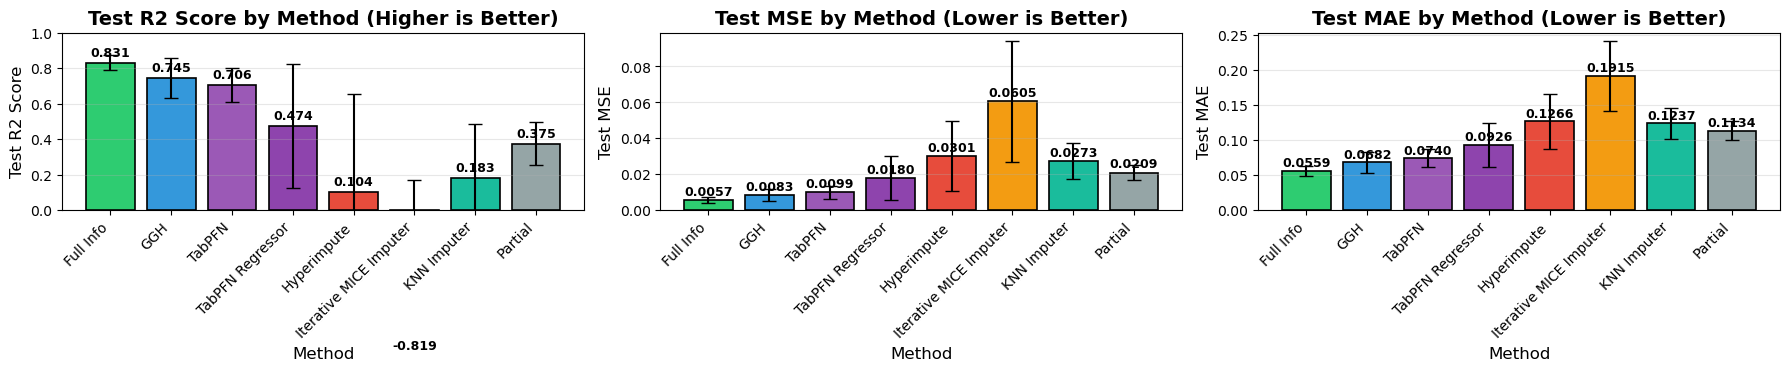


STATISTICAL TESTS: GGH vs All Methods (Paired t-test)

GGH vs Full Info:
  GGH R2: 0.7455 vs Full Info: 0.8310
  Difference: -0.0855 (Full Info better)
  t=-2.559, p=0.022734 *

GGH vs Partial:
  GGH R2: 0.7455 vs Partial: 0.3747
  Difference: +0.3708 (GGH better)
  t=8.056, p=0.000001 ***

GGH vs TabPFN:
  GGH R2: 0.7455 vs TabPFN: 0.7057
  Difference: +0.0397 (GGH better)
  t=0.898, p=0.384248 

GGH vs TabPFN Regressor:
  GGH R2: 0.7455 vs TabPFN Regressor: 0.4741
  Difference: +0.2713 (GGH better)
  t=2.544, p=0.023379 *

GGH vs Hyperimpute:
  GGH R2: 0.7455 vs Hyperimpute: 0.1043
  Difference: +0.6412 (GGH better)
  t=4.251, p=0.000806 ***

GGH vs Iterative MICE Imputer:
  GGH R2: 0.7455 vs Iterative MICE Imputer: -0.8192
  Difference: +1.5647 (GGH better)
  t=6.207, p=0.000023 ***

GGH vs KNN Imputer:
  GGH R2: 0.7455 vs KNN Imputer: 0.1829
  Difference: +0.5625 (GGH better)
  t=5.749, p=0.000050 ***

CONCLUSION

Full Info R2 (Oracle): 0.8310
GGH R2: 0.7455
Best Imputation (TabPF

In [5]:
# =============================================================================
# COMPARISON: GGH vs Imputation Methods (Self-Contained)
# =============================================================================
# This cell runs ALL methods: Full Info, Partial, GGH, and Imputation methods
# No dependency on previous benchmark cells
# =============================================================================

from GGH.imputation_methods import Imputer

# Imputation methods to compare (including both TabPFN variants)
IMPUTATION_METHODS = ["TabPFN", "TabPFN Regressor", "Hyperimpute", "Iterative MICE Imputer", "KNN Imputer"]
IMPUTATION_EPOCHS = BENCHMARK_EPOCHS  # Same epochs for fair comparison

print("=" * 80)
print("FULL COMPARISON: GGH vs Imputation Methods on Airfoil Self-Noise")
print("=" * 80)
print(f"Methods compared:")
print(f"  - Full Info (oracle)")
print(f"  - Partial (baseline)")
print(f"  - GGH Soft Refinement")
print(f"  - Imputation: {IMPUTATION_METHODS}")
print(f"Training epochs: {IMPUTATION_EPOCHS}")
print(f"Number of runs: {BENCHMARK_N_RUNS}")
print("=" * 80)

# Store results for all methods
all_method_results = {
    'Full Info': {'r2': [], 'mse': [], 'mae': []},
    'Partial': {'r2': [], 'mse': [], 'mae': []},
    'GGH': {'r2': [], 'mse': [], 'mae': []},
}
for method in IMPUTATION_METHODS:
    all_method_results[method] = {'r2': [], 'mse': [], 'mae': []}

# Find valid r_states (same logic as original benchmark)
valid_r_states = []
for r_state in range(2000):
    if len(valid_r_states) >= BENCHMARK_N_RUNS:
        break
    set_to_deterministic(r_state)
    DO_test = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                           partial_perc, r_state, device=DEVICE)
    if not DO_test.lack_partial_coverage:
        valid_r_states.append(r_state)

print(f"Using r_states: {valid_r_states}")

# Run benchmark for each r_state
for run_idx, r_state in enumerate(valid_r_states):
    print(f"\n{'='*60}")
    print(f"RUN {run_idx + 1}/{BENCHMARK_N_RUNS} (rand_state={r_state})")
    print(f"{'='*60}")
    
    set_to_deterministic(r_state)
    
    # Create DataOperator
    DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                      partial_perc, r_state, device=DEVICE)
    
    n_shared = len(DO.inpt_vars)
    n_hyp = len(DO.miss_vars)
    out_size = len(DO.target_vars)
    
    partial_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    
    # === Full Info ===
    print("Training Full Info...")
    set_to_deterministic(r_state)
    INSPECT_full = Inspector(results_path, hidden_size)
    DO_full = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                           partial_perc, r_state, device=DEVICE)
    DO_full, TVM_full, model_full = full_experiment(
        "full info", DO_full, INSPECT_full, batch_size, hidden_size, output_size,
        BENCHMARK_EPOCHS, r_state, results_path, dropout, lr, nu, final_analysis=False
    )
    full_r2 = INSPECT_full.calculate_val_r2score(DO, TVM_full, model_full, data="test")
    
    model_full.eval()
    with torch.no_grad():
        test_inputs, test_targets = DO.get_test_tensors(use_info="full info")
        test_preds = model_full(test_inputs)
        full_mse = torch.nn.functional.mse_loss(test_preds, test_targets).item()
        full_mae = torch.nn.functional.l1_loss(test_preds, test_targets).item()
    
    all_method_results['Full Info']['r2'].append(full_r2)
    all_method_results['Full Info']['mse'].append(full_mse)
    all_method_results['Full Info']['mae'].append(full_mae)
    print(f"  Full Info: R2={full_r2:.4f}, MSE={full_mse:.6f}, MAE={full_mae:.4f}")
    
    # === GGH Soft Refinement ===
    print("Running GGH Soft Refinement...")
    set_to_deterministic(r_state)
    gid_weights, ggh_precision, _, partial_weight_dynamic = run_ggh_soft_refinement(DO, r_state)
    
    set_to_deterministic(r_state + 200)
    model_ggh = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN, 
                                          MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size).to(DEVICE)
    model_ggh, ggh_best_epoch, ggh_best_val_loss = train_with_soft_weights(
        DO, model_ggh, sample_weights=gid_weights, partial_gids=partial_gids,
        partial_weight=partial_weight_dynamic, lr=GGH_BENCHMARK_LR, n_epochs=GGH_FINAL_EPOCHS
    )
    ggh_mse, ggh_mae, ggh_r2 = evaluate_on_test(DO, model_ggh)
    
    all_method_results['GGH']['r2'].append(ggh_r2)
    all_method_results['GGH']['mse'].append(ggh_mse)
    all_method_results['GGH']['mae'].append(ggh_mae)
    print(f"  GGH: R2={ggh_r2:.4f}, MSE={ggh_mse:.6f}, MAE={ggh_mae:.4f}")
    
    # === Partial (same architecture as GGH for fair comparison) ===
    print("Training Partial...")
    set_to_deterministic(r_state + 300)
    model_partial = HypothesisAmplifyingModel(n_shared, n_hyp, MODEL_SHARED_HIDDEN,
                                              MODEL_HYPOTHESIS_HIDDEN, MODEL_FINAL_HIDDEN, out_size).to(DEVICE)
    model_partial, _, _ = train_with_soft_weights(
        DO, model_partial, sample_weights={}, partial_gids=partial_gids,
        partial_weight=1.0, lr=GGH_BENCHMARK_LR, n_epochs=GGH_FINAL_EPOCHS
    )
    partial_mse, partial_mae, partial_r2 = evaluate_on_test(DO, model_partial)
    
    all_method_results['Partial']['r2'].append(partial_r2)
    all_method_results['Partial']['mse'].append(partial_mse)
    all_method_results['Partial']['mae'].append(partial_mae)
    print(f"  Partial: R2={partial_r2:.4f}, MSE={partial_mse:.6f}, MAE={partial_mae:.4f}")
    
    # === Imputation Methods ===
    for imput_method in IMPUTATION_METHODS:
        print(f"Running {imput_method}...")
        set_to_deterministic(r_state)
        
        try:
            # Create new DataOperator for imputation
            DO_imp = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                  partial_perc, r_state, device=DEVICE)
            
            # Impute and create dataloader
            AM_imp = AlgoModulators(DO_imp, lr=lr)
            IMP = Imputer(DO_imp)
            dataloader_imp = IMP.impute_w_sel(DO_imp, imput_method, batch_size)
            
            # Train model with imputed data
            set_to_deterministic(r_state)
            model_imp = initialize_model(DO_imp, dataloader_imp, hidden_size, r_state, dropout=dropout)
            
            TVM_imp = TrainValidationManager("use imputation", IMPUTATION_EPOCHS, dataloader_imp, 
                                              batch_size, r_state, results_path, 
                                              imput_method=imput_method, final_analysis=False)
            TVM_imp.train_model(DO_imp, AM_imp, model_imp, final_analysis=False)
            
            # Evaluate on test
            INSPECT_imp = Inspector(results_path, hidden_size)
            imp_r2 = INSPECT_imp.calculate_val_r2score(DO_imp, TVM_imp, model_imp, data="test")
            
            # Calculate MSE and MAE
            model_imp.eval()
            with torch.no_grad():
                test_inputs, test_targets = DO_imp.get_test_tensors(use_info="full info")
                test_preds = model_imp(test_inputs)
                imp_mse = torch.nn.functional.mse_loss(test_preds, test_targets).item()
                imp_mae = torch.nn.functional.l1_loss(test_preds, test_targets).item()
            
            all_method_results[imput_method]['r2'].append(imp_r2)
            all_method_results[imput_method]['mse'].append(imp_mse)
            all_method_results[imput_method]['mae'].append(imp_mae)
            print(f"  {imput_method}: R2={imp_r2:.4f}, MSE={imp_mse:.6f}, MAE={imp_mae:.4f}")
            
        except Exception as e:
            print(f"  {imput_method}: FAILED - {str(e)}")
            all_method_results[imput_method]['r2'].append(np.nan)
            all_method_results[imput_method]['mse'].append(np.nan)
            all_method_results[imput_method]['mae'].append(np.nan)


# =============================================================================
# SUMMARY TABLE
# =============================================================================
print(f"\n{'='*80}")
print("SUMMARY: All Methods Comparison")
print(f"{'='*80}")

# Create summary dataframe
summary_data = []
method_order = ['Full Info', 'GGH', 'TabPFN', 'TabPFN Regressor', 'Hyperimpute', 'Iterative MICE Imputer', 'KNN Imputer', 'Partial']

for method in method_order:
    if method in all_method_results:
        r2_vals = [v for v in all_method_results[method]['r2'] if not np.isnan(v)]
        mse_vals = [v for v in all_method_results[method]['mse'] if not np.isnan(v)]
        mae_vals = [v for v in all_method_results[method]['mae'] if not np.isnan(v)]
        
        if r2_vals:
            summary_data.append({
                'Method': method,
                'R2 Mean': np.mean(r2_vals),
                'R2 Std': np.std(r2_vals),
                'MSE Mean': np.mean(mse_vals),
                'MSE Std': np.std(mse_vals),
                'MAE Mean': np.mean(mae_vals),
                'MAE Std': np.std(mae_vals),
                'N Runs': len(r2_vals)
            })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# =============================================================================
# BAR PLOT: R2, MSE, MAE Comparison
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Colors for each method
colors = {
    'Full Info': '#2ecc71',           # Green (oracle)
    'GGH': '#3498db',                 # Blue (our method)
    'TabPFN': '#9b59b6',              # Purple (classifier)
    'TabPFN Regressor': '#8e44ad',    # Dark purple (regressor)
    'Hyperimpute': '#e74c3c',         # Red
    'Iterative MICE Imputer': '#f39c12',  # Orange
    'KNN Imputer': '#1abc9c',         # Teal
    'Partial': '#95a5a6',             # Gray (baseline)
}

# Get data for plotting
methods_to_plot = [m for m in method_order if m in all_method_results and len([v for v in all_method_results[m]['r2'] if not np.isnan(v)]) > 0]
x_pos = np.arange(len(methods_to_plot))

# Plot 1: R2 Score (higher is better)
ax1 = axes[0]
r2_means = [np.nanmean(all_method_results[m]['r2']) for m in methods_to_plot]
r2_stds = [np.nanstd(all_method_results[m]['r2']) for m in methods_to_plot]
bar_colors = [colors.get(m, '#cccccc') for m in methods_to_plot]

bars1 = ax1.bar(x_pos, r2_means, yerr=r2_stds, capsize=5, color=bar_colors, edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Method', fontsize=12)
ax1.set_ylabel('Test R2 Score', fontsize=12)
ax1.set_title('Test R2 Score by Method (Higher is Better)', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(methods_to_plot, rotation=45, ha='right', fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1.0)

# Add value labels on bars
for bar, val in zip(bars1, r2_means):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: MSE (lower is better)
ax2 = axes[1]
mse_means = [np.nanmean(all_method_results[m]['mse']) for m in methods_to_plot]
mse_stds = [np.nanstd(all_method_results[m]['mse']) for m in methods_to_plot]

bars2 = ax2.bar(x_pos, mse_means, yerr=mse_stds, capsize=5, color=bar_colors, edgecolor='black', linewidth=1.2)
ax2.set_xlabel('Method', fontsize=12)
ax2.set_ylabel('Test MSE', fontsize=12)
ax2.set_title('Test MSE by Method (Lower is Better)', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(methods_to_plot, rotation=45, ha='right', fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars2, mse_means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{val:.4f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 3: MAE (lower is better)
ax3 = axes[2]
mae_means = [np.nanmean(all_method_results[m]['mae']) for m in methods_to_plot]
mae_stds = [np.nanstd(all_method_results[m]['mae']) for m in methods_to_plot]

bars3 = ax3.bar(x_pos, mae_means, yerr=mae_stds, capsize=5, color=bar_colors, edgecolor='black', linewidth=1.2)
ax3.set_xlabel('Method', fontsize=12)
ax3.set_ylabel('Test MAE', fontsize=12)
ax3.set_title('Test MAE by Method (Lower is Better)', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(methods_to_plot, rotation=45, ha='right', fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars3, mae_means):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{val:.4f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{results_path}/ggh_vs_imputation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# STATISTICAL TESTS: GGH vs Each Method
# =============================================================================
print(f"\n{'='*80}")
print("STATISTICAL TESTS: GGH vs All Methods (Paired t-test)")
print(f"{'='*80}")

ggh_r2_arr = np.array(all_method_results['GGH']['r2'])

for method in ['Full Info', 'Partial'] + IMPUTATION_METHODS:
    method_r2_arr = np.array(all_method_results[method]['r2'])
    
    # Remove NaN pairs
    valid_mask = ~np.isnan(method_r2_arr)
    if valid_mask.sum() >= 2:
        ggh_valid = ggh_r2_arr[valid_mask]
        method_valid = method_r2_arr[valid_mask]
        
        t_stat, p_val = stats.ttest_rel(ggh_valid, method_valid)
        diff = np.mean(ggh_valid) - np.mean(method_valid)
        
        sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
        winner = 'GGH' if diff > 0 else method
        
        print(f"\nGGH vs {method}:")
        print(f"  GGH R2: {np.mean(ggh_valid):.4f} vs {method}: {np.mean(method_valid):.4f}")
        print(f"  Difference: {diff:+.4f} ({winner} better)")
        print(f"  t={t_stat:.3f}, p={p_val:.6f} {sig}")

print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
ggh_mean_r2 = np.mean(all_method_results['GGH']['r2'])
partial_mean_r2 = np.mean(all_method_results['Partial']['r2'])
full_mean_r2 = np.mean(all_method_results['Full Info']['r2'])

# Find best imputation method
valid_imputers = [m for m in IMPUTATION_METHODS if len([v for v in all_method_results[m]['r2'] if not np.isnan(v)]) > 0]
if valid_imputers:
    best_imputer = max(valid_imputers, key=lambda m: np.nanmean(all_method_results[m]['r2']))
    best_imputer_r2 = np.nanmean(all_method_results[best_imputer]['r2'])
    
    print(f"\nFull Info R2 (Oracle): {full_mean_r2:.4f}")
    print(f"GGH R2: {ggh_mean_r2:.4f}")
    print(f"Best Imputation ({best_imputer}) R2: {best_imputer_r2:.4f}")
    print(f"Partial R2 (Baseline): {partial_mean_r2:.4f}")
    
    print(f"\n>>> GGH vs Best Imputation ({best_imputer}): {ggh_mean_r2 - best_imputer_r2:+.4f}")
    print(f">>> GGH vs Partial: {ggh_mean_r2 - partial_mean_r2:+.4f}")
    print(f">>> GGH closes {((ggh_mean_r2 - partial_mean_r2) / (full_mean_r2 - partial_mean_r2)) * 100:.1f}% of the gap to Full Info")
else:
    print("No valid imputation results to compare.")


SUMMARY: All Methods Comparison

                Method   R2 Mean   R2 Std  MSE Mean  MSE Std  MAE Mean  MAE Std  N Runs
             Full Info  0.830963 0.042078  0.005665 0.001528  0.055889 0.007488      15
                   GGH  0.737115 0.076996  0.008849 0.002962  0.071325 0.013025      15
                TabPFN  0.767290 0.078832  0.007712 0.002262  0.065191 0.009178      15
      TabPFN Regressor  0.771179 0.087996  0.007720 0.003080  0.065818 0.012716      15
           Hyperimpute -0.096023 0.972213  0.034384 0.024555  0.132379 0.049424      15
Iterative MICE Imputer -0.324412 0.562119  0.043466 0.015129  0.163508 0.032522      15
           KNN Imputer  0.309807 0.177422  0.023109 0.006074  0.116050 0.015599      15
               Partial  0.468316 0.133722  0.017588 0.003151  0.103944 0.011912      15


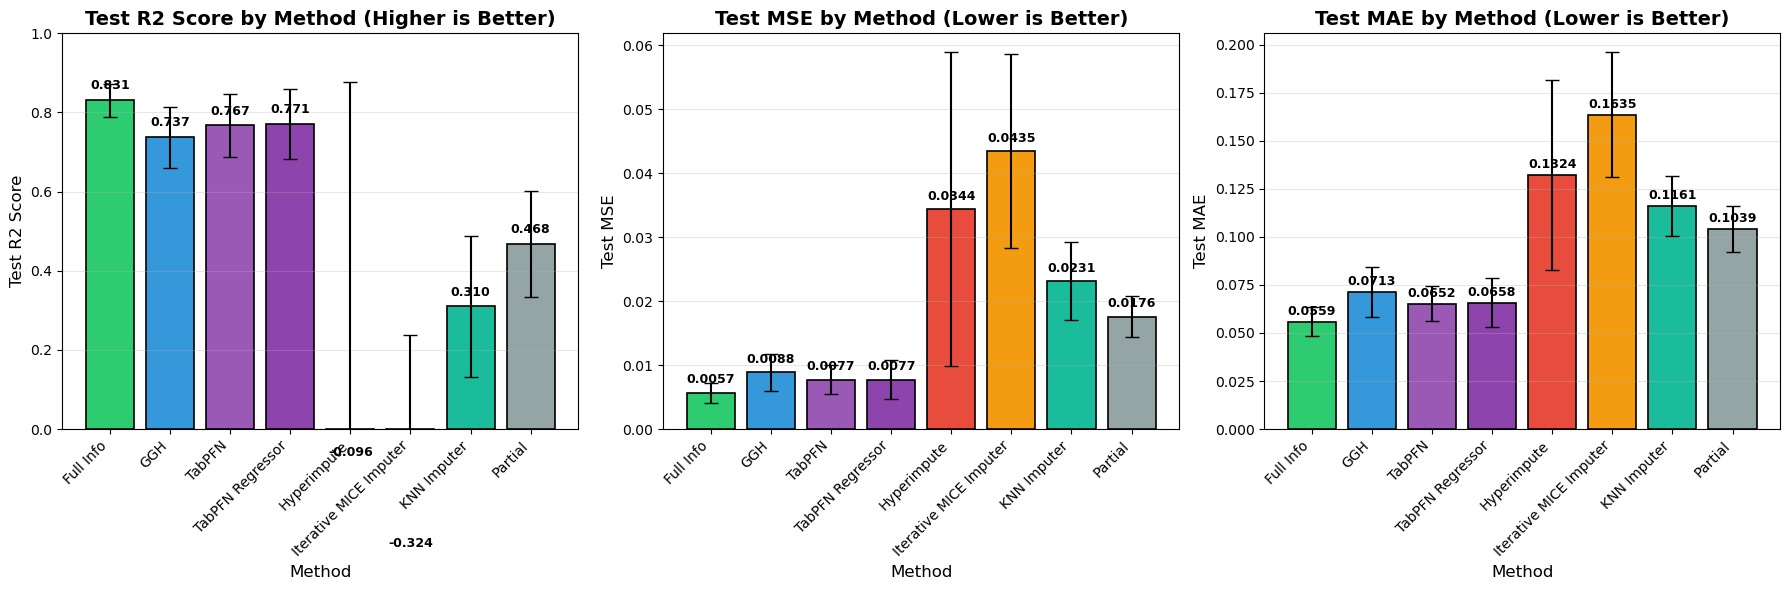


STATISTICAL TESTS: GGH vs All Methods (Paired t-test)

GGH vs Full Info:
  GGH R2: 0.7371 vs Full Info: 0.8310
  Difference: -0.0938 (Full Info better)
  t=-3.993, p=0.001335 **

GGH vs Partial:
  GGH R2: 0.7371 vs Partial: 0.4683
  Difference: +0.2688 (GGH better)
  t=6.785, p=0.000009 ***

GGH vs TabPFN:
  GGH R2: 0.7371 vs TabPFN: 0.7673
  Difference: -0.0302 (TabPFN better)
  t=-1.085, p=0.296432 

GGH vs TabPFN Regressor:
  GGH R2: 0.7371 vs TabPFN Regressor: 0.7712
  Difference: -0.0341 (TabPFN Regressor better)
  t=-1.292, p=0.217311 

GGH vs Hyperimpute:
  GGH R2: 0.7371 vs Hyperimpute: -0.0960
  Difference: +0.8331 (GGH better)
  t=3.211, p=0.006283 **

GGH vs Iterative MICE Imputer:
  GGH R2: 0.7371 vs Iterative MICE Imputer: -0.3244
  Difference: +1.0615 (GGH better)
  t=6.796, p=0.000009 ***

GGH vs KNN Imputer:
  GGH R2: 0.7371 vs KNN Imputer: 0.3098
  Difference: +0.4273 (GGH better)
  t=7.542, p=0.000003 ***

CONCLUSION

Full Info R2 (Oracle): 0.8310
GGH R2: 0.7371
Best

In [6]:
# =============================================================================
# SUMMARY TABLE
# =============================================================================
print(f"\n{'='*80}")
print("SUMMARY: All Methods Comparison")
print(f"{'='*80}")

# Create summary dataframe
summary_data = []
method_order = ['Full Info', 'GGH', 'TabPFN', 'TabPFN Regressor', 'Hyperimpute', 'Iterative MICE Imputer', 'KNN Imputer', 'Partial']

for method in method_order:
    if method in all_method_results:
        r2_vals = [v for v in all_method_results[method]['r2'] if not np.isnan(v)]
        mse_vals = [v for v in all_method_results[method]['mse'] if not np.isnan(v)]
        mae_vals = [v for v in all_method_results[method]['mae'] if not np.isnan(v)]
        
        if r2_vals:
            summary_data.append({
                'Method': method,
                'R2 Mean': np.mean(r2_vals),
                'R2 Std': np.std(r2_vals),
                'MSE Mean': np.mean(mse_vals),
                'MSE Std': np.std(mse_vals),
                'MAE Mean': np.mean(mae_vals),
                'MAE Std': np.std(mae_vals),
                'N Runs': len(r2_vals)
            })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# =============================================================================
# BAR PLOT: R2, MSE, MAE Comparison
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Colors for each method
colors = {
    'Full Info': '#2ecc71',           # Green (oracle)
    'GGH': '#3498db',                 # Blue (our method)
    'TabPFN': '#9b59b6',              # Purple (classifier)
    'TabPFN Regressor': '#8e44ad',    # Dark purple (regressor)
    'Hyperimpute': '#e74c3c',         # Red
    'Iterative MICE Imputer': '#f39c12',  # Orange
    'KNN Imputer': '#1abc9c',         # Teal
    'Partial': '#95a5a6',             # Gray (baseline)
}

# Get data for plotting
methods_to_plot = [m for m in method_order if m in all_method_results and len([v for v in all_method_results[m]['r2'] if not np.isnan(v)]) > 0]
x_pos = np.arange(len(methods_to_plot))

# Plot 1: R2 Score (higher is better)
ax1 = axes[0]
r2_means = [np.nanmean(all_method_results[m]['r2']) for m in methods_to_plot]
r2_stds = [np.nanstd(all_method_results[m]['r2']) for m in methods_to_plot]
bar_colors = [colors.get(m, '#cccccc') for m in methods_to_plot]

bars1 = ax1.bar(x_pos, r2_means, yerr=r2_stds, capsize=5, color=bar_colors, edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Method', fontsize=12)
ax1.set_ylabel('Test R2 Score', fontsize=12)
ax1.set_title('Test R2 Score by Method (Higher is Better)', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(methods_to_plot, rotation=45, ha='right', fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1.0)

# Add value labels on bars
for bar, val in zip(bars1, r2_means):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: MSE (lower is better)
ax2 = axes[1]
mse_means = [np.nanmean(all_method_results[m]['mse']) for m in methods_to_plot]
mse_stds = [np.nanstd(all_method_results[m]['mse']) for m in methods_to_plot]

bars2 = ax2.bar(x_pos, mse_means, yerr=mse_stds, capsize=5, color=bar_colors, edgecolor='black', linewidth=1.2)
ax2.set_xlabel('Method', fontsize=12)
ax2.set_ylabel('Test MSE', fontsize=12)
ax2.set_title('Test MSE by Method (Lower is Better)', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(methods_to_plot, rotation=45, ha='right', fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars2, mse_means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{val:.4f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 3: MAE (lower is better)
ax3 = axes[2]
mae_means = [np.nanmean(all_method_results[m]['mae']) for m in methods_to_plot]
mae_stds = [np.nanstd(all_method_results[m]['mae']) for m in methods_to_plot]

bars3 = ax3.bar(x_pos, mae_means, yerr=mae_stds, capsize=5, color=bar_colors, edgecolor='black', linewidth=1.2)
ax3.set_xlabel('Method', fontsize=12)
ax3.set_ylabel('Test MAE', fontsize=12)
ax3.set_title('Test MAE by Method (Lower is Better)', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(methods_to_plot, rotation=45, ha='right', fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars3, mae_means):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{val:.4f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{results_path}/ggh_vs_imputation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# STATISTICAL TESTS: GGH vs Each Method
# =============================================================================
print(f"\n{'='*80}")
print("STATISTICAL TESTS: GGH vs All Methods (Paired t-test)")
print(f"{'='*80}")

ggh_r2_arr = np.array(all_method_results['GGH']['r2'])

for method in ['Full Info', 'Partial'] + IMPUTATION_METHODS:
    method_r2_arr = np.array(all_method_results[method]['r2'])
    
    # Remove NaN pairs
    valid_mask = ~np.isnan(method_r2_arr)
    if valid_mask.sum() >= 2:
        ggh_valid = ggh_r2_arr[valid_mask]
        method_valid = method_r2_arr[valid_mask]
        
        t_stat, p_val = stats.ttest_rel(ggh_valid, method_valid)
        diff = np.mean(ggh_valid) - np.mean(method_valid)
        
        sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
        winner = 'GGH' if diff > 0 else method
        
        print(f"\nGGH vs {method}:")
        print(f"  GGH R2: {np.mean(ggh_valid):.4f} vs {method}: {np.mean(method_valid):.4f}")
        print(f"  Difference: {diff:+.4f} ({winner} better)")
        print(f"  t={t_stat:.3f}, p={p_val:.6f} {sig}")

print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
ggh_mean_r2 = np.mean(all_method_results['GGH']['r2'])
partial_mean_r2 = np.mean(all_method_results['Partial']['r2'])
full_mean_r2 = np.mean(all_method_results['Full Info']['r2'])

# Find best imputation method
valid_imputers = [m for m in IMPUTATION_METHODS if len([v for v in all_method_results[m]['r2'] if not np.isnan(v)]) > 0]
if valid_imputers:
    best_imputer = max(valid_imputers, key=lambda m: np.nanmean(all_method_results[m]['r2']))
    best_imputer_r2 = np.nanmean(all_method_results[best_imputer]['r2'])
    
    print(f"\nFull Info R2 (Oracle): {full_mean_r2:.4f}")
    print(f"GGH R2: {ggh_mean_r2:.4f}")
    print(f"Best Imputation ({best_imputer}) R2: {best_imputer_r2:.4f}")
    print(f"Partial R2 (Baseline): {partial_mean_r2:.4f}")
    
    print(f"\n>>> GGH vs Best Imputation ({best_imputer}): {ggh_mean_r2 - best_imputer_r2:+.4f}")
    print(f">>> GGH vs Partial: {ggh_mean_r2 - partial_mean_r2:+.4f}")
    print(f">>> GGH closes {((ggh_mean_r2 - partial_mean_r2) / (full_mean_r2 - partial_mean_r2)) * 100:.1f}% of the gap to Full Info")
else:
    print("No valid imputation results to compare.")